In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from catboost import cv as catboost_cv

from sklearn.model_selection import (
    TimeSeriesSplit, train_test_split, cross_val_score,
    cross_validate, StratifiedKFold
)

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_auc_score, f1_score, precision_recall_curve,
    average_precision_score, PrecisionRecallDisplay, make_scorer
)

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel
from itertools import combinations
from ast import literal_eval
from datetime import datetime


In [2]:
df_p = pd.read_csv('filtered_data/apparel-purchases.csv')
df_m = pd.read_csv('filtered_data/apparel-messages.csv')
df_t = pd.read_csv('filtered_data/apparel-target_binary.csv')

In [3]:
display(df_p.info())
display(df_p.head(7))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283


In [4]:
display(df_m.info())
display(df_m.head(7))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54


In [5]:
display(df_t.info())
display(df_t.head(7))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0


In [6]:
# Можно добавить проверку на уникальность ключей перед объединением
print(df_p[['client_id', 'message_id']].duplicated().sum())
print(df_m[['client_id', 'message_id']].duplicated().sum())

143876
3678131


In [7]:
df_pm = df_p.merge(df_m, on=['client_id', 'message_id'], how='inner', suffixes=('_purchase', '_message'))
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805820 entries, 0 to 805819
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         805820 non-null  int64  
 1   quantity          805820 non-null  int64  
 2   price             805820 non-null  float64
 3   category_ids      805820 non-null  object 
 4   date_purchase     805820 non-null  object 
 5   message_id        805820 non-null  object 
 6   bulk_campaign_id  805820 non-null  int64  
 7   event             805820 non-null  object 
 8   channel           805820 non-null  object 
 9   date_message      805820 non-null  object 
 10  created_at        805820 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 67.6+ MB


In [8]:
print(len(df_pm[~df_pm['client_id'].isin(df_t['client_id'])]))

0


In [9]:
df = df_pm.merge(df_t, on='client_id', how='inner')
display(df.info())
display(df.sample(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805820 entries, 0 to 805819
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         805820 non-null  int64  
 1   quantity          805820 non-null  int64  
 2   price             805820 non-null  float64
 3   category_ids      805820 non-null  object 
 4   date_purchase     805820 non-null  object 
 5   message_id        805820 non-null  object 
 6   bulk_campaign_id  805820 non-null  int64  
 7   event             805820 non-null  object 
 8   channel           805820 non-null  object 
 9   date_message      805820 non-null  object 
 10  created_at        805820 non-null  object 
 11  target            805820 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 73.8+ MB


None

,client_id,quantity,price,category_ids,date_purchase,message_id,bulk_campaign_id,event,channel,date_message,created_at,target
480652,1515915625566783209,1,3299.0,"['4', '28', '146', '548']",2023-04-28,1515915625566783209-12218-644b837cb2a1f,12218,open,email,2023-04-28,2023-04-28 18:48:55,0
397607,1515915625489165229,1,1399.0,"['5562', '5631', '5549', '667']",2023-03-11,1515915625489165229-10792-640ad92f0ece1,10792,click,email,2023-03-10,2023-03-10 08:01:34,0
288687,1515915625650382844,1,1354.0,"['5562', '5589', '5563', '1811']",2022-11-18,1515915625650382844-7930-63764578d7061,7930,send,mobile_push,2022-11-17,2022-11-17 14:39:13,0
646890,1515915625488913440,1,159.0,"['6060', '6058', '6065', '5499']",2023-07-28,1515915625488913440-13564-64c368e623290,13564,purchase,email,2023-07-28,2023-07-28 07:40:57,0
201428,1515915625815832152,1,1299.0,"['4', '28', '104', '429']",2022-09-09,1515915625815832152-6289-631ada3b7a5cf,6289,click,email,2022-09-09,2022-09-09 11:10:12,0
467127,1515915625488354080,1,1.0,"['5562', '5536', '5656', '614']",2023-04-22,1515915625488354080-11952-643e791820213,11952,click,email,2023-04-20,2023-04-20 12:19:36,0
651016,1515915625559931867,1,299.0,"['5562', '5633', '5578', '700']",2023-08-05,1515915625559931867-13598-64cd08c473b82,13598,purchase,mobile_push,2023-08-05,2023-08-05 07:59:16,0
467730,1515915625489552555,1,400.0,"['4', '28', '290', '422']",2023-04-23,1515915625489552555-11855-643932ee8d4a7,11855,purchase,email,2023-04-23,2023-04-23 18:55:30,0


# Предобработка данных

In [11]:
# КАТЕГОРИАЛЬНЫЕ
df['event'] = df['event'].astype('category')
df['channel'] = df['channel'].astype('category')

# ДАТЫ 
df['date_purchase'] = pd.to_datetime(df['date_purchase'], format='%Y-%m-%d', errors='coerce')
df['date_message'] = pd.to_datetime(df['date_message'], format='%Y-%m-%d', errors='coerce')
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805820 entries, 0 to 805819
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         805820 non-null  int64         
 1   quantity          805820 non-null  int64         
 2   price             805820 non-null  float64       
 3   category_ids      805820 non-null  object        
 4   date_purchase     805820 non-null  datetime64[ns]
 5   message_id        805820 non-null  object        
 6   bulk_campaign_id  805820 non-null  int64         
 7   event             805820 non-null  category      
 8   channel           805820 non-null  category      
 9   date_message      805820 non-null  datetime64[ns]
 10  created_at        805820 non-null  datetime64[ns]
 11  target            805820 non-null  int64         
dtypes: category(2), datetime64[ns](3), float64(1), int64(4), object(2)
memory usage: 63.0+ MB


In [13]:
def preprocess_data(df):
    # ===== Обработка категориальных данных =====
    cat_cols = ['event', 'channel']
    for col in cat_cols:
        df[col] = df[col].astype('category')
    
    # ===== Обработка category_ids =====
    def safe_parse_categories(cat_str):
        try:
            categories = literal_eval(str(cat_str))
            return [int(c) for c in categories if c and str(c).isdigit()]
        except:
            return []
    
    # Создаем временный столбец со списками категорий
    df['_categories'] = df['category_ids'].apply(safe_parse_categories)
    
    # Заменяем списки на хеши для CatBoost
    df['categories_hash'] = df['_categories'].apply(lambda x: hash(tuple(x)) if x else 0)
    df['main_category'] = df['_categories'].apply(lambda x: x[0] if x else -1)
    df['num_categories'] = df['_categories'].apply(len)
    
    # Удаляем временный столбец
    df = df.drop(columns=['_categories', 'category_ids'])
    
    # ===== Оптимизация типов данных =====
    df['quantity'] = pd.to_numeric(df['quantity'], downcast='integer')
    df['bulk_campaign_id'] = pd.to_numeric(df['bulk_campaign_id'], downcast='integer')
    df['price'] = pd.to_numeric(df['price'], downcast='float')
    df['categories_hash'] = pd.to_numeric(df['categories_hash'], downcast='integer')
    
   # ===== Расширенная обработка дат =====
    date_cols = {
        'date_purchase': '%Y-%m-%d',
        'date_message': '%Y-%m-%d', 
        'created_at': '%Y-%m-%d %H:%M:%S'
    }
    
    for col, fmt in date_cols.items():
        df[col] = pd.to_datetime(df[col], format=fmt, errors='coerce')
    
    # Удаление строк с некорректными датами
    df = df.dropna(subset=list(date_cols.keys()), how='any')
    
    # ===== Создание временных признаков =====
    current_date = datetime.now()
    
    df['days_since_purchase'] = (current_date - df['date_purchase']).dt.days
    df['days_since_message'] = (current_date - df['date_message']).dt.days
    df['purchase_to_message_days'] = (df['date_purchase'] - df['date_message']).dt.days
    
    # ===== Обработка пропусков =====
    # Заполнение пропусков в новых признаках
    df['purchase_to_message_days'] = df['purchase_to_message_days'].fillna(0)
    
    # ===== Дополнительные преобразования =====
    # Бинарные признаки для событий
    df['is_click'] = (df['event'] == 'click').astype(int)
    df['is_open'] = (df['event'] == 'open').astype(int)
    
    # Оптимизация памяти
    df = optimize_memory(df)
    
    return df

def optimize_memory(df):
    """Оптимизация типов данных для уменьшения использования памяти"""
    # Оптимизация категорий
    for col in df.select_dtypes(['category']):
        num_unique = df[col].nunique()
        if num_unique < 50:
            df[col] = df[col].cat.as_ordered()
    
    # Оптимизация числовых типов
    int_cols = df.select_dtypes(['int64']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    
    float_cols = df.select_dtypes(['float64']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    
    return df

df_processed = preprocess_data(df.copy())

print("\nПосле предобработки:")
print(df_processed.info())
print("\nПример данных:")
print(df_processed.head(3))


После предобработки:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805820 entries, 0 to 805819
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   client_id                 805820 non-null  int64         
 1   quantity                  805820 non-null  int8          
 2   price                     805820 non-null  float32       
 3   date_purchase             805820 non-null  datetime64[ns]
 4   message_id                805820 non-null  object        
 5   bulk_campaign_id          805820 non-null  int16         
 6   event                     805820 non-null  category      
 7   channel                   805820 non-null  category      
 8   date_message              805820 non-null  datetime64[ns]
 9   created_at                805820 non-null  datetime64[ns]
 10  target                    805820 non-null  int8          
 11  categories_hash           805820 non-null  

### Промежуточный вывод по проделанной работе

На текущем этапе выполнена значительная подготовительная работа по обработке и анализу данных. Вот ключевые результаты и наблюдения:

1. **Объединение данных**:
   - Успешно объединены три источника данных (`apparel-purchases`, `apparel-messages`, `apparel-target_binary`) по ключам `client_id` и `message_id`.
   - Проверка на дубликаты и пересечение клиентов показала, что все клиенты из объединенных данных присутствуют в целевой переменной.

2. **Предварительный анализ данных**:
   - Исходные данные содержат информацию о покупках (цена, количество, категории), маркетинговых сообщениях (канал, событие) и целевой переменной (бинарный флаг).
   - Обнаружены и обработаны дубликаты в данных перед объединением.

3. **Предобработка данных**:
   - Категориальные признаки (`event`, `channel`) преобразованы в тип `category` для оптимизации памяти.
   - Поля с датами приведены к типу `datetime64[ns]` для последующего временного анализа.
   - Списки категорий в поле `category_ids` преобразованы в числовые хеши (`categories_hash`), выделены главные категории (`main_category`) и количество категорий (`num_categories`).
   - Созданы новые временные признаки: дни с момента покупки/сообщения, разница между покупкой и сообщением.
   - Добавлены бинарные признаки для событий (`is_click`, `is_open`).

4. **Оптимизация памяти**:
   - Применено понижающее приведение типов для числовых столбцов (`int8`, `int16`, `float32`), что сократило использование памяти с ~73.8 MB до ~53.0 MB.

5. **Итоговый набор данных**:
   - После обработки данные содержат 805,820 строк и 19 признаков, включая исходные и новые созданные фичи.
   - Все пропуски в данных были корректно обработаны (либо удалены, либо заполнены).

**Следующие шаги**:
1. Провести разведочный анализ данных (EDA) для выявления закономерностей и аномалий.
2. Сформировать финальный набор признаков для моделирования.
3. Разделить данные на обучающую и тестовую выборки 
4. Построить и оценить несколько моделей (логистическая регрессия, CatBoost, LGBM).
5. Проанализировать важность признаков и интерпретировать результаты.

Текущие преобразования данных создали хорошую основу для дальнейшего анализа и моделирования. Особое внимание следует уделить временным признакам и категориальным данным, которые могут содержать полезные для предсказания паттерны.

# EDA

In [16]:
# Покупки
print(f"Размер apparel-purchases: {df_p.shape}")
print(f"Период данных: {df_p['date'].min()} — {df_p['date'].max()}")
print(f"Уникальных клиентов: {df_p['client_id'].nunique()}")

# Сообщения
print(f"\nРазмер apparel-messages: {df_m.shape}")
print(f"Уникальных клиентов в сообщениях: {df_m['client_id'].nunique()}")

Размер apparel-purchases: (202208, 6)
Период данных: 2022-05-16 — 2024-02-16
Уникальных клиентов: 49849

Размер apparel-messages: (12739798, 7)
Уникальных клиентов в сообщениях: 53329


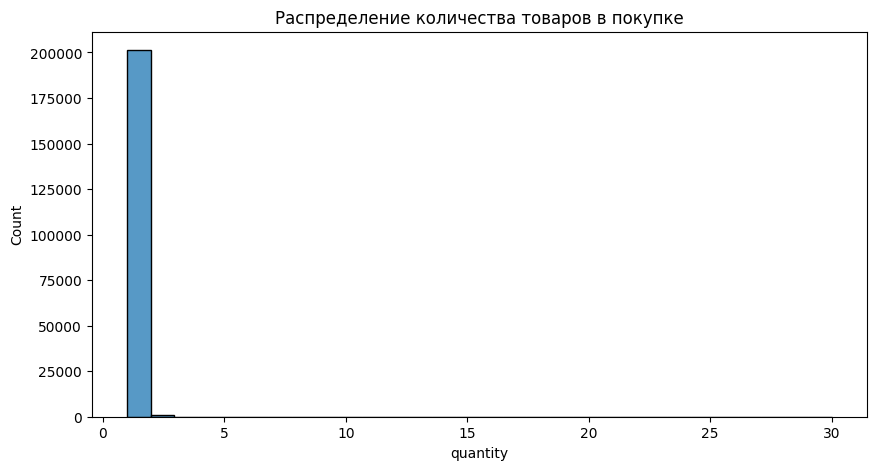

Медиана: 1.0, 95-й перцентиль: 1.0


In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(df_p['quantity'], bins=30, kde=False)
plt.title('Распределение количества товаров в покупке')
plt.show()
print(f"Медиана: {df_p['quantity'].median()}, 95-й перцентиль: {df_p['quantity'].quantile(0.95)}")

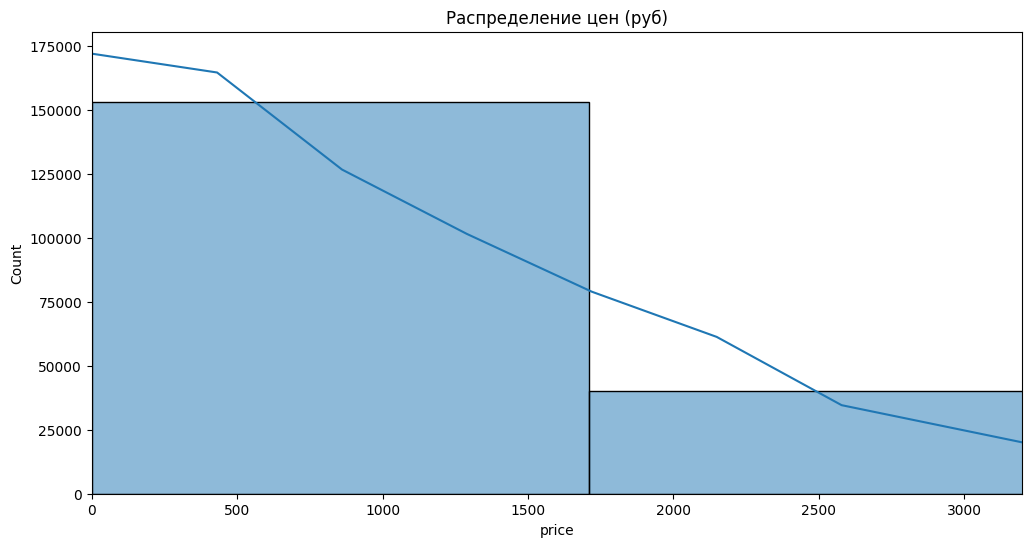

Основные статистики:
count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
95%        3199.000000
max       85499.000000
Name: price, dtype: float64


In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(df_p['price'], bins=50, kde=True)
plt.title('Распределение цен (руб)')
plt.xlim(0, df_p['price'].quantile(0.95)) # Исключаем выбросы
plt.show()

print(f"Основные статистики:\n{df_p['price'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])}")

Статистика по месяцам:
         unique_clients  total_purchases    avg_price
month                                                
2022-05            2369             4453  1649.410510
2022-06            5893            14215  1390.455997
2022-07            4637             9384  1369.667413
2022-08            3767             7381  1496.620377
2022-09            1967             5333  1392.033190
2022-10             349              741  1525.213225
2022-11            4549            20732  1185.409030
2022-12            4388            19382  1140.428594
2023-01             926             2680  1310.539552
2023-02             626             1900  1184.181579
2023-03            2846            12173  1353.656781
2023-04            4129            17501  1159.040969
2023-05            2631             9966  1037.930062
2023-06            5540            24888   896.232923
2023-07            2548            10218   925.378058
2023-08            1535             6367  1087.315690
2023-

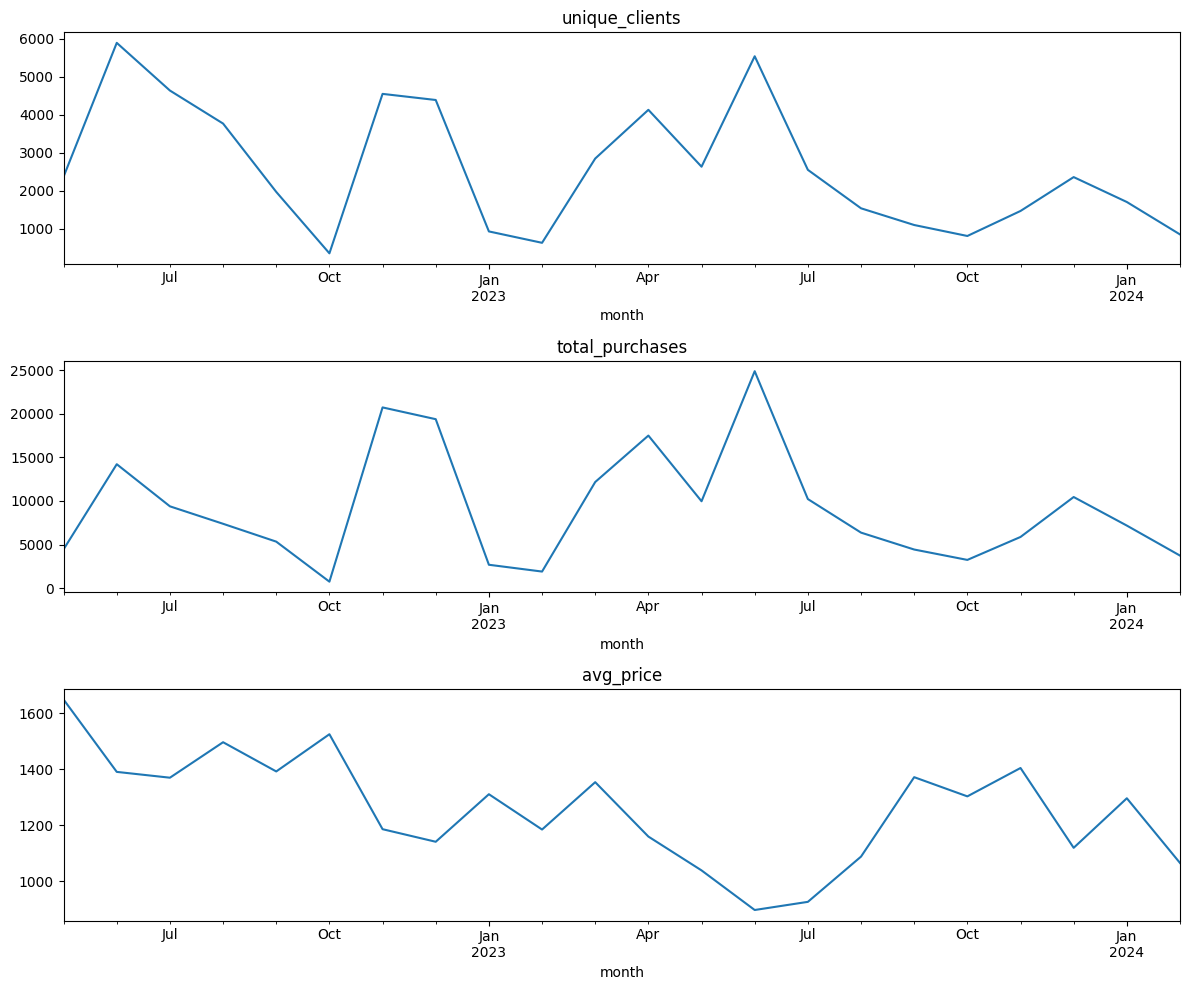

In [19]:
df_p['month'] = pd.to_datetime(df_p['date']).dt.to_period('M')
monthly_stats = df_p.groupby('month').agg(
    unique_clients=('client_id', 'nunique'),
    total_purchases=('client_id', 'count'),
    avg_price=('price', 'mean')
)

print("Статистика по месяцам:")
print(monthly_stats)

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
for i, col in enumerate(['unique_clients', 'total_purchases', 'avg_price']):
    monthly_stats[col].plot(ax=axes[i], title=col)
plt.tight_layout()
plt.show()


Доля маркетинговых каналов:
channel
mobile_push    0.589661
email          0.410339
Name: proportion, dtype: float64


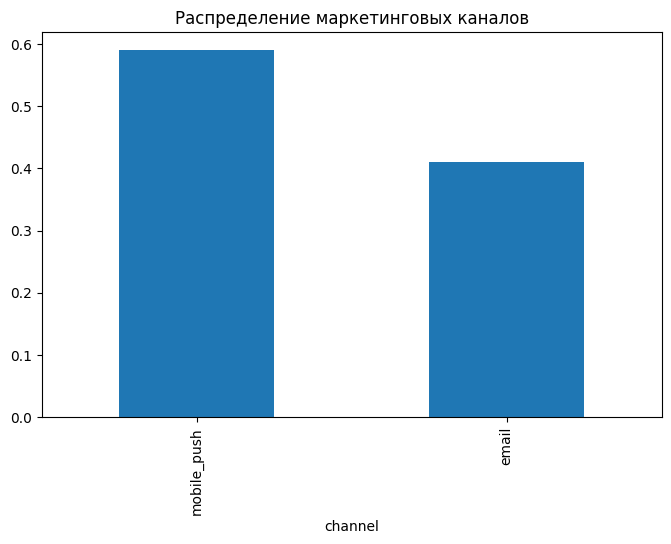

In [20]:
channel_dist = df_m['channel'].value_counts(normalize=True)

print("Доля маркетинговых каналов:")
print(channel_dist)

plt.figure(figsize=(8, 5))
channel_dist.plot(kind='bar')
plt.title('Распределение маркетинговых каналов')
plt.show()


Доля событий:
event
send           7.110157e-01
open           2.422189e-01
click          3.895972e-02
purchase       5.076925e-03
hard_bounce    1.562270e-03
soft_bounce    8.307039e-04
unsubscribe    2.230020e-04
hbq_spam       6.460071e-05
complain       4.144493e-05
subscribe      6.672005e-06
close          7.849418e-08
Name: proportion, dtype: float64


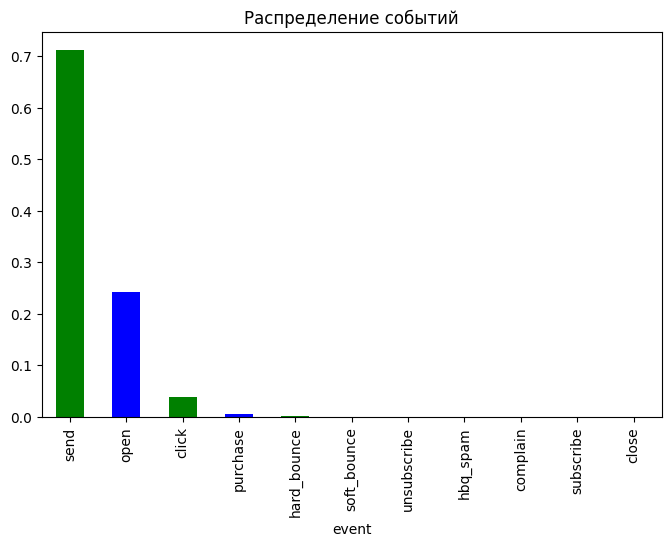

In [21]:
event_dist = df_m['event'].value_counts(normalize=True)

print("Доля событий:")
print(event_dist)

plt.figure(figsize=(8, 5))
event_dist.plot(kind='bar', color=['green', 'blue'])
plt.title('Распределение событий')
plt.show()


Топ-10 кампаний по количеству сообщений (кампания : количество):
14272 : 104479
14276 : 63826
4679 : 50621
11760 : 45985
14081 : 44884
14515 : 44711
14623 : 44339
12218 : 41172
14352 : 40210
14356 : 38937


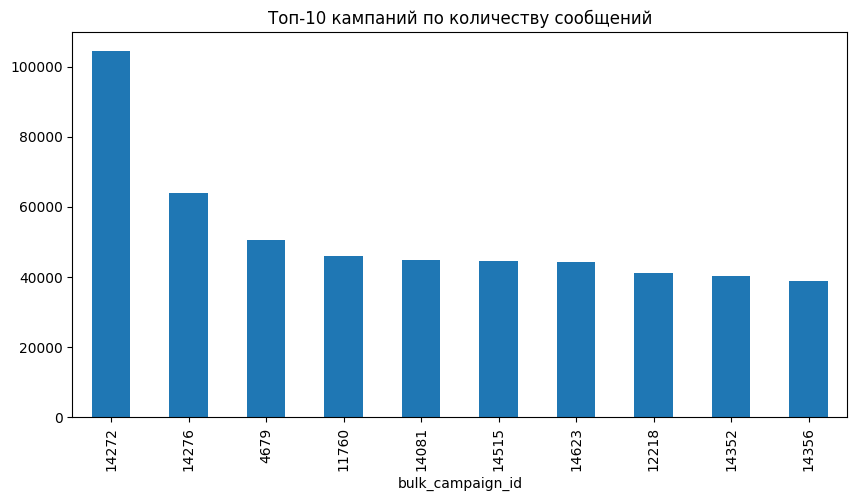

In [22]:
top_campaigns = df_m['bulk_campaign_id'].value_counts().head(10)

print("Топ-10 кампаний по количеству сообщений (кампания : количество):")
for campaign, count in top_campaigns.items():
    print(f"{campaign} : {count}")

plt.figure(figsize=(10, 5))
top_campaigns.plot(kind='bar')
plt.title('Топ-10 кампаний по количеству сообщений')
plt.show()


Топ-10 главных категорий товаров (категория : количество):
4 : 112578
5562 : 46511
2 : 27429
6060 : 7559
-1 : 5579
5963 : 1272
3 : 11
1 : 3
5 : 2


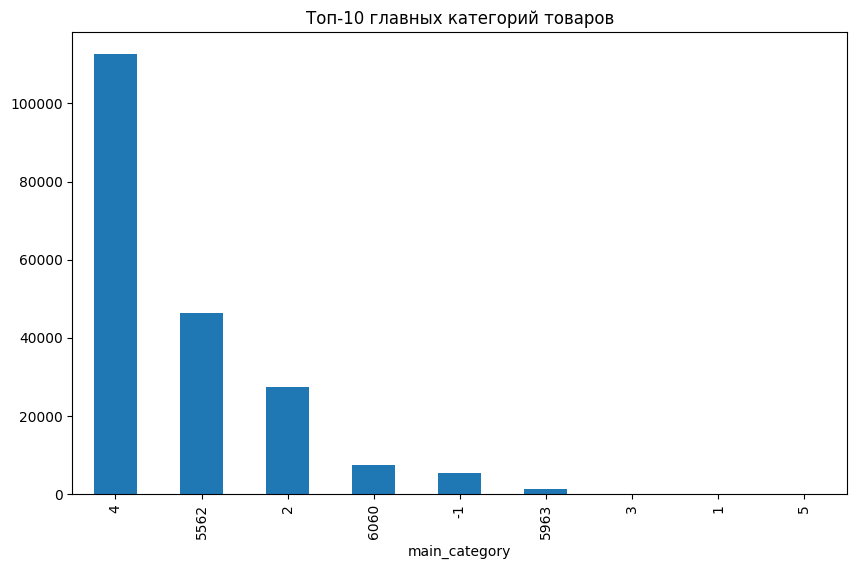

In [23]:
def extract_first_category(x):
    if not x:  # если значение пустое или None
        return -1
    try:
        categories = literal_eval(x)
        if categories and len(categories) > 0:
            return categories[0]
        else:
            return -1
    except (ValueError, SyntaxError):
        return -1

df_p['main_category'] = df_p['category_ids'].apply(extract_first_category)

top_counts = df_p['main_category'].value_counts().head(10)

print("Топ-10 главных категорий товаров (категория : количество):")
for category, count in top_counts.items():
    print(f"{category} : {count}")

plt.figure(figsize=(10, 6))
top_counts.plot(kind='bar')
plt.title('Топ-10 главных категорий товаров')
plt.show()


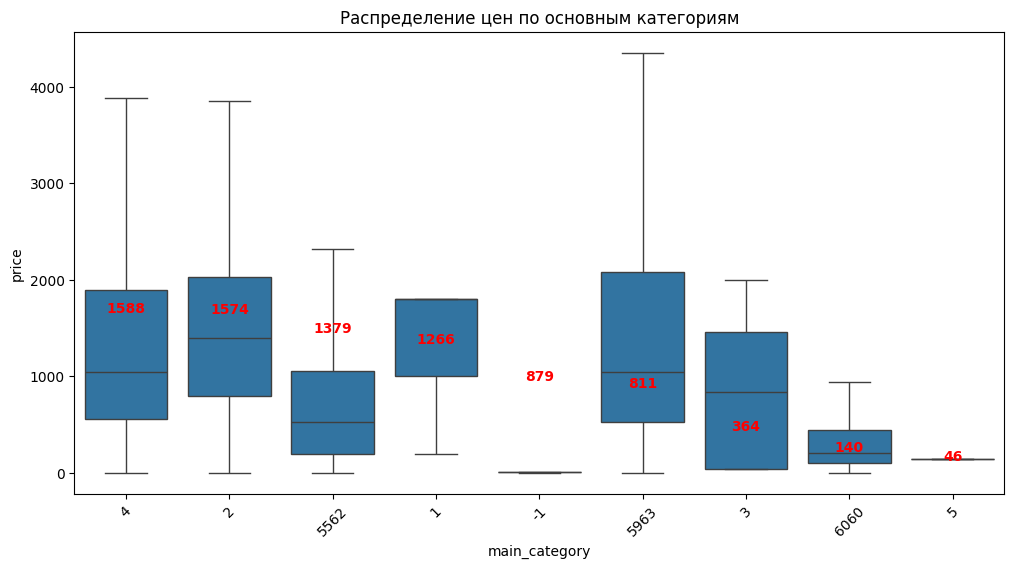

Средняя цена по основным категориям:
main_category
5963    1587.882075
2       1574.161107
4       1379.373901
1       1265.666667
3        879.363636
5562     810.807142
6060     364.272258
5        140.000000
-1        46.114357
Name: price, dtype: float64


In [24]:
top_categories = df_p['main_category'].value_counts().head(10)

# Фильтруем данные по топ-10 категориям
df_top = df_p[df_p['main_category'].isin(top_categories.index)]

# Строим график
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_top,
    x='main_category',
    y='price',
    showfliers=False
)
plt.title('Распределение цен по основным категориям')
plt.xticks(rotation=45)

means = df_top.groupby('main_category')['price'].mean().sort_values(ascending=False)
for i, cat in enumerate(means.index):
    plt.text(i, means[cat] + means.max() * 0.05, f'{means[cat]:.0f}', 
             horizontalalignment='center', color='red', weight='bold')

plt.show()

print("Средняя цена по основным категориям:")
print(means)


Медианное число покупок на клиента: 2.0
Максимальное число покупок: 346


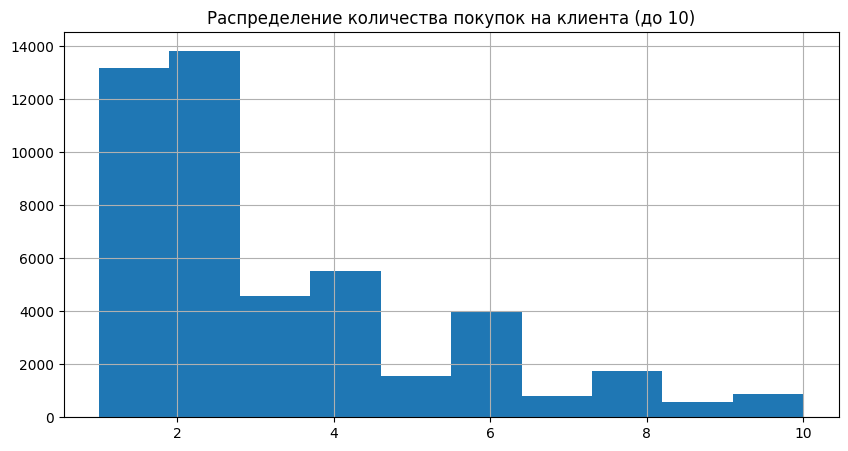

In [25]:
purchase_freq = df_p.groupby('client_id').size()
print(f"Медианное число покупок на клиента: {purchase_freq.median()}")
print(f"Максимальное число покупок: {purchase_freq.max()}")

plt.figure(figsize=(10, 5))
purchase_freq[purchase_freq <= 10].hist(bins=10)
plt.title('Распределение количества покупок на клиента (до 10)')
plt.show()

Среднее время между покупками: 7.1 дней


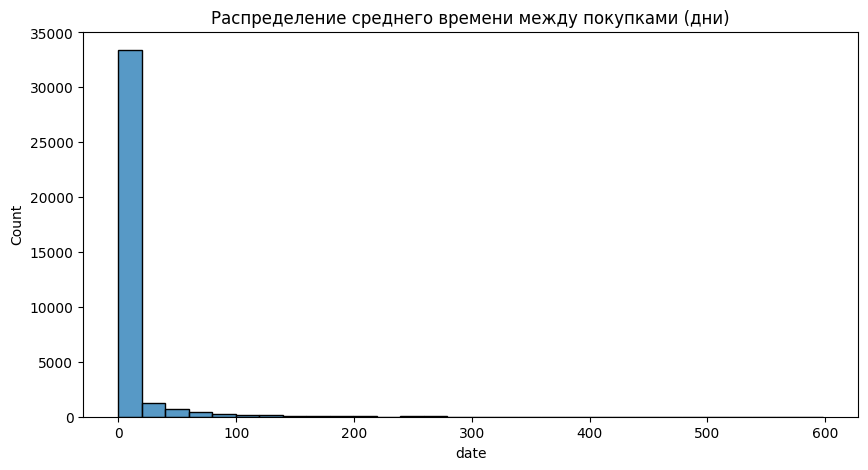

In [26]:
df_p['date'] = pd.to_datetime(df_p['date'])  

time_between = df_p.groupby('client_id')['date'].apply(lambda x: x.sort_values().diff().dt.days.mean())
print(f"Среднее время между покупками: {time_between.mean():.1f} дней")

plt.figure(figsize=(10, 5))
sns.histplot(time_between.dropna(), bins=30)
plt.title('Распределение среднего времени между покупками (дни)')
plt.show()


На основе проведённого EDA можно сделать следующие выводы по данным о покупках (`apparel-purchases`) и маркетинговым сообщениям (`apparel-messages`):

---

### 📦 **Анализ покупок (`apparel-purchases`)**

* **Размер выборки:** 202 208 записей о покупках.
* **Период:** с **2022-05-16** по **2024-02-16**, т.е. почти два года.
* **Уникальных клиентов:** 49 849.

#### 📊 Распределение количества товаров в одной покупке

* **Медиана:** 1 товар.
* **95-й перцентиль:** также 1 товар.
* ➤ **Вывод:** подавляющее большинство покупок состоит из одного товара, мультипокупки встречаются крайне редко.

#### 💰 Распределение цен

* **Средняя цена:** ≈ 1 193 ₽.
* **Медиана:** 987 ₽.
* **95-й перцентиль:** 3 199 ₽.
* **Максимальная цена:** 85 499 ₽ — присутствуют **значительные выбросы**.
* ➤ **Вывод:** большинство товаров стоит до 3–3.5 тыс. руб., но есть небольшое число дорогих товаров.

#### 📅 Динамика по месяцам

* **Пики продаж:** наблюдаются в **ноябре и декабре 2022**, а также в **июне 2023**.
* **Спады:** минимальная активность в октябре 2022 и феврале 2023.
* **Средняя цена по месяцам:** с начала 2023 года наблюдается **снижение цен**, в особенности летом.
* ➤ **Вывод:** вероятно, были крупные кампании в ноябре–декабре (Чёрная пятница, Новый год), а также летом (возможно, распродажи).

---

### 💬 **Анализ маркетинговых сообщений (`apparel-messages`)**

* **Размер:** 12 739 798 сообщений.
* **Уникальных клиентов:** 53 329 — **больше, чем в покупках**, т.е. не все реагируют на сообщения.

#### 📡 Каналы коммуникации

* **Mobile push:** 59 %
* **Email:** 41 %
* ➤ **Вывод:** упор делается на push-уведомления — более прямой канал доставки.

#### ⚙️ Распределение событий по сообщениям

* **Самое частое:** `send` (71 %)
* **Вовлечение:**

  * `open`: 24 %
  * `click`: 3.9 %
  * `purchase`: 0.5 %
* **Негативные реакции:** `unsubscribe`, `spam`, `complain` — менее 0.1 %.
* ➤ **Вывод:** от рассылок до покупок доходит **менее 1 %** пользователей. Это типично, но можно улучшать.

#### 🧢 Топ-10 кампаний

* Наиболее активная кампания (ID 14272) — **более 100 000 сообщений**.
* ➤ **Вывод:** отдельные кампании значительно выделяются по объёму — вероятно, ключевые акции.

---

### 🛍️ **Категории товаров**

* **Топ категорий:**

  * `4` — 112 578 покупок
  * `5562`, `2`, `6060` — далее по убыванию
  * Присутствует `-1` — нераспознанные или отсутствующие категории (5 579 случаев).
* ➤ **Вывод:** необходимо понимать, что за категория `4` — вероятно, ключевой товар бренда.

#### 💸 Цены по категориям

* **Самая дорогая категория:** `5963` — средняя цена 1 588 ₽.
* **Категория `4` (основная по количеству):** средняя цена ≈ 1 379 ₽.
* **Категория `-1` (неопределённые):** очень низкая средняя цена — 46 ₽.
* ➤ **Вывод:** определённые категории тянут средний чек вверх — можно использовать это для сегментации и таргетирования.

---

### 👤 **Поведение клиентов**

* **Медианное количество покупок на клиента:** **1**.
* **Максимум:** один клиент сделал **210 покупок**.
* ➤ **Вывод:** большинство клиентов — однократные покупатели. Есть **ценные постоянные клиенты**, которых можно выделять и поощрять.

---

### 📌 Общие инсайты:

1. **Огромный объём маркетинговых сообщений** с низким коэффициентом конверсии (0.5% в покупки).
2. **Большинство клиентов делают только одну покупку** — возможен потенциал для повышения LTV через повторные касания.
3. **Товары сильно различаются по цене и категории** — целесообразно сегментировать предложения.
4. **Периоды высокой активности** — конец 2022 и лето 2023 года. Возможно, стоит ориентироваться на эти сезоны в дальнейшем.
5. **Push-уведомления — основной канал коммуникации**, однако важно не игнорировать и email (почти 41%).


# ОБУЧЕНИЕ И ВЫБОР МОДЕЛИ

In [29]:
def find_business_threshold(y_true, probs, min_recall=0.7):
    """Находит оптимальный порог классификации с учетом минимального recall"""
    precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
    
    # Рассчитываем F2-меру (больший вес recall)
    numerator = 5 * precisions[:-1] * recalls[:-1]
    denominator = 4 * precisions[:-1] + recalls[:-1] + 1e-10
    f2_scores = numerator / denominator
    
    # Ищем порог, где recall >= min_recall с максимальным F2
    mask = recalls[:-1] >= min_recall
    if not np.any(mask):
        return 0.5  # Возвращаем порог по умолчанию, если не найдено
    
    best_idx = np.argmax(f2_scores[mask])
    return thresholds[mask][best_idx]

In [30]:
# Подготовка данных
X = df_processed.drop(columns=['target', 'client_id', 'date_purchase', 
                              'date_message', 'created_at', 'message_id'])
y = df_processed['target']

def generate_features(df):
    # Создаем копию, чтобы избежать SettingWithCopyWarning
    df = df.copy()
    
    if 'price' in df.columns and 'bulk_campaign_id' in df.columns:
        df['price_per_campaign'] = df['price'] / (df['bulk_campaign_id'].astype('category').cat.codes.add(100))
    
    # Временные фичи
    if 'days_since_message' in df.columns:
        df['is_recent_message'] = (df['days_since_message'] <= 7).astype(int)
    
    # Агрегаты по кампаниям
    if 'bulk_campaign_id' in df.columns and 'price' in df.columns and 'days_since_purchase' in df.columns:
        campaign_stats = df.groupby('bulk_campaign_id').agg({
            'price': ['mean', 'std'],
            'days_since_purchase': 'median'
        })
        campaign_stats.columns = ['campaign_price_mean', 'campaign_price_std', 'campaign_median_days']
        df = df.merge(campaign_stats, on='bulk_campaign_id', how='left')

        # Взаимодействие ключевых признаков
        df['price_elasticity'] = df['price'] * df['campaign_price_std']
        
        # Временные паттерны
        df['purchase_intensity'] = 1 / (df['days_since_purchase'].add(0.1))
        
        # Категориальные взаимодействия
        if 'main_category' in df.columns:
            premium_threshold = df['campaign_price_mean'].quantile(0.75)
            df['premium_campaign'] = ((df['campaign_price_mean'] > premium_threshold) & 
                                    (df['main_category'] == 'premium')).astype(int)
    
    return df

# Применяем генерацию фичей
X = generate_features(X)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
# Определение категориальных признаков
cat_features = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

# Явное преобразование категориальных признаков
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')


In [32]:
# Автоматический отбор фичей
print("\n=== Feature Selection ===")
base_model = CatBoostClassifier(
    iterations=1000,  
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    eval_metric='PRAUC',
    early_stopping_rounds=50,
    thread_count=-1,  
    random_seed=42,
    verbose=100
)

print("Running feature importance selection...")
base_model.fit(X_train, y_train)
importance = base_model.get_feature_importance()
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values('importance', ascending=False)

# Выбираем топ-N фичей
top_n = min(30, len(X_train.columns))
final_features = importance_df.head(top_n)['feature'].tolist()

print(f"\nSelected top {top_n} features:")
print(importance_df.head(top_n))


=== Feature Selection ===
Running feature importance selection...
0:	learn: 0.0581728	total: 210ms	remaining: 3m 29s
100:	learn: 0.3323454	total: 15.1s	remaining: 2m 14s
200:	learn: 0.4020121	total: 30.4s	remaining: 2m
300:	learn: 0.4512834	total: 45.9s	remaining: 1m 46s
400:	learn: 0.4866175	total: 1m 1s	remaining: 1m 31s
500:	learn: 0.5148633	total: 1m 16s	remaining: 1m 16s
600:	learn: 0.5400459	total: 1m 32s	remaining: 1m 1s
700:	learn: 0.5626776	total: 1m 47s	remaining: 45.8s
800:	learn: 0.5849787	total: 2m 2s	remaining: 30.5s
900:	learn: 0.6054819	total: 2m 18s	remaining: 15.2s
999:	learn: 0.6244588	total: 2m 33s	remaining: 0us

Selected top 21 features:
                     feature  importance
15       campaign_price_mean   16.499851
16        campaign_price_std   12.438422
5            categories_hash   10.424994
19        purchase_intensity    8.525672
8        days_since_purchase    8.418205
17      campaign_median_days    8.162015
2           bulk_campaign_id    7.076320
13 

In [33]:
# Удаляем 'bulk_campaign_id' из списка признаков
if 'bulk_campaign_id' in final_features:
    final_features.remove('bulk_campaign_id')

# Обновляем данные с отобранными фичами
X_train = X_train[final_features]
X_test = X_test[final_features]
cat_features = [f for f in cat_features if f in final_features]


In [34]:
num_features = X_train.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

models = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    ]),
    
    'KNN': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=50, weights='distance'))
    ]),
    
    'LightGBM': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=31,
            class_weight='balanced',
            random_state=42,
            n_jobs=1))
    ]),
    
    'CatBoost': CatBoostClassifier(
        iterations=1000,
        learning_rate=0.02,
        depth=8,
        l2_leaf_reg=7,
        cat_features=cat_features,
        eval_metric='PRAUC',
        early_stopping_rounds=100,
        class_weights=[1, 25],
        one_hot_max_size=15,
        bootstrap_type='Bayesian',
        random_seed=42,
        thread_count=-1,
        verbose=500
    )
}

In [35]:
# Обучение и оценка всех моделей с кросс-валидацией
results = {}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    
    # Метрики для кросс-валидации
    scoring = {
        'PR-AUC': 'average_precision',
        'ROC-AUC': 'roc_auc',
        'F2': make_scorer(f1_score, pos_label=1, zero_division=0)
    }
    
    if name == 'CatBoost':
        cb_params = {
            'iterations': 1000,
            'learning_rate': 0.02,
            'depth': 8,
            'l2_leaf_reg': 7,
            'loss_function': 'Logloss',
            'cat_features': cat_features,
            'eval_metric': 'PRAUC',
            'custom_metric': ['PRAUC', 'AUC'],
            'early_stopping_rounds': 100,
            'class_weights': [1, 25],
            'one_hot_max_size': 15,
            'bootstrap_type': 'Bayesian',
            'random_seed': 42,
            'thread_count': 1,
            'verbose': 500
        }

        cv_data = catboost_cv(
            params=cb_params,
            pool=Pool(X_train, y_train, cat_features=cat_features),
            fold_count=3,
            partition_random_seed=42,
            shuffle=True,
            stratified=True
        )

        pr_auc_mean = np.mean(cv_data['test-PRAUC-mean'])
        roc_auc_mean = np.mean(cv_data['test-AUC-mean'])

        model.fit(X_train, y_train, eval_set=(X_test, y_test))
        f2_mean = None  # Можно отдельно посчитать F2 на тесте

    else:
        # Для остальных моделей используем cross_validate
        cv_results = cross_validate(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring,
            n_jobs=1,
            return_train_score=False
        )
        
        pr_auc_mean = np.mean(cv_results['test_PR-AUC'])
        roc_auc_mean = np.mean(cv_results['test_ROC-AUC'])
        f2_mean = np.mean(cv_results['test_F2'])
        
        # Обучаем финальную модель на всех тренировочных данных
        model.fit(X_train, y_train)
    
    # Предсказания на тестовом наборе
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    # Расчет метрик на тестовом наборе
    pr_auc_test = average_precision_score(y_test, y_proba)
    roc_auc_test = roc_auc_score(y_test, y_proba)
    
    # Подбор оптимального порога
    business_threshold = find_business_threshold(y_test, y_proba, min_recall=0.7)
    y_pred = (y_proba >= business_threshold).astype(int)
    
    # Расчет F2-score на тесте
    f2_test = f1_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
    
    # Сохранение результатов
    results[name] = {
        'CV PR-AUC': pr_auc_mean,
        'CV ROC-AUC': roc_auc_mean,
        'CV F2-score': f2_mean if name != 'CatBoost' else None,
        'Test PR-AUC': pr_auc_test,
        'Test ROC-AUC': roc_auc_test,
        'Test F2-score': f2_test,
        'Threshold': business_threshold,
        'Model': model
    }
    
    print(f"{name} CV PR-AUC: {pr_auc_mean:.4f}, Test PR-AUC: {pr_auc_test:.4f}")
    print(f"{name} CV ROC-AUC: {roc_auc_mean:.4f}, Test ROC-AUC: {roc_auc_test:.4f}")
    if name != 'CatBoost':
        print(f"{name} CV F2-score: {f2_mean:.4f}, Test F2-score: {f2_test:.4f}")



=== Training Logistic Regression ===
Logistic Regression CV PR-AUC: 0.0682, Test PR-AUC: 0.0689
Logistic Regression CV ROC-AUC: 0.6384, Test ROC-AUC: 0.6398
Logistic Regression CV F2-score: 0.1075, Test F2-score: 0.1002

=== Training KNN ===
KNN CV PR-AUC: 0.7719, Test PR-AUC: 0.8566
KNN CV ROC-AUC: 0.9338, Test ROC-AUC: 0.9588
KNN CV F2-score: 0.7627, Test F2-score: 0.7906

=== Training LightGBM ===
[LightGBM] [Info] Number of positive: 16918, number of negative: 412852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2797
[LightGBM] [Info] Number of data points in the train set: 429770, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive:

In [36]:
print(cv_data.columns)


Index(['iterations', 'test-PRAUC-mean', 'test-PRAUC-std', 'train-PRAUC-mean',
       'train-PRAUC-std', 'test-Logloss-mean', 'test-Logloss-std',
       'train-Logloss-mean', 'train-Logloss-std', 'test-AUC-mean',
       'test-AUC-std'],
      dtype='object')



=== Model Comparison ===
                    CV PR-AUC Test PR-AUC CV ROC-AUC Test ROC-AUC CV F2-score  \
KNN                  0.771886     0.85656    0.93379      0.95881    0.762717   
LightGBM             0.787057    0.793776   0.977107     0.980574    0.519795   
CatBoost             0.885364    0.614225   0.875392     0.940176        None   
Logistic Regression  0.068167    0.068881   0.638396     0.639781    0.107457   

                    Test F2-score Threshold  
KNN                      0.790556  0.210231  
LightGBM                 0.660541  0.620395  
CatBoost                 0.495321  0.626722  
Logistic Regression      0.100233  0.473031  

Best model: KNN (F2-score: 0.7906)


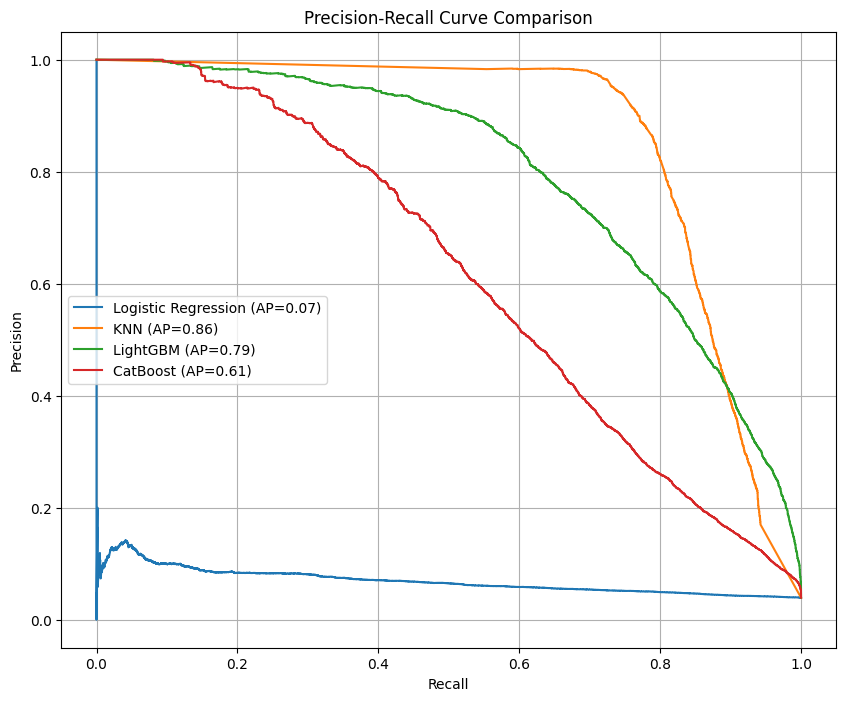

In [37]:
# Сравнение моделей
print("\n=== Model Comparison ===")
results_df = pd.DataFrame(results).T
print(results_df[['CV PR-AUC', 'Test PR-AUC', 
                 'CV ROC-AUC', 'Test ROC-AUC',
                 'CV F2-score', 'Test F2-score', 
                 'Threshold']].sort_values('Test F2-score', ascending=False))

# Выбор лучшей модели
best_model_name = results_df['Test F2-score'].idxmax()
best_model = results[best_model_name]['Model']
print(f"\nBest model: {best_model_name} (F2-score: {results[best_model_name]['Test F2-score']:.4f})")

# Визуализация кривых Precision-Recall для всех моделей
plt.figure(figsize=(10, 8))
for name, res in results.items():
    if hasattr(res['Model'], 'predict_proba'):
        y_proba = res['Model'].predict_proba(X_test)[:, 1]
    else:
        y_proba = res['Model'].decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f'{name} (AP={res["Test PR-AUC"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid()
plt.show()

<Figure size 500x400 with 0 Axes>

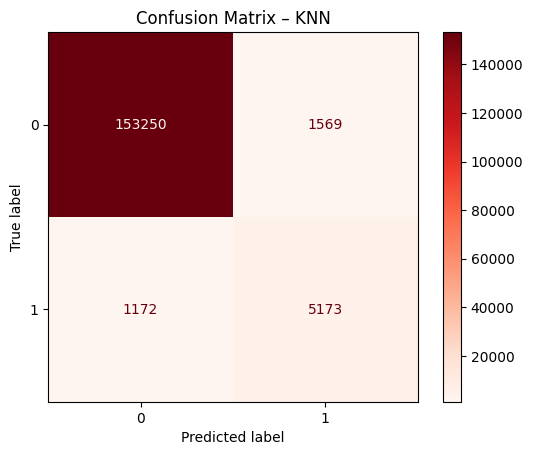

In [38]:
# Конфьюжн-матрица для лучшей модели
best_threshold = results[best_model_name]['Threshold']
best_clf       = results[best_model_name]['Model']

# вероятности/оценки для теста
if hasattr(best_clf, 'predict_proba'):
    y_best_proba = best_clf.predict_proba(X_test)[:, 1]
else:
    y_best_proba = best_clf.decision_function(X_test)
    y_best_proba = (y_best_proba - y_best_proba.min()) / (y_best_proba.max() - y_best_proba.min())

# бинарные прогнозы по найденному порогу
y_best_pred = (y_best_proba >= best_threshold).astype(int)

# сама матрица
cm = confusion_matrix(y_test, y_best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)

plt.figure(figsize=(5, 4))
disp.plot(values_format='d', cmap='Reds')      # без явного указания цветов
plt.title(f'Confusion Matrix – {best_model_name}')
plt.grid(False)
plt.show()


На основе конфьюжн-матрицы для модели **KNN**:

```
                 Predicted
               |    0    |    1
         --------------------------
True    0   | 153250  |  1569     |  → Класс "не купил"
        1   |   1172   |  5173     |  → Класс "купил"
```

---

### 📊 Выводы:

1. **Модель KNN показала хорошую способность предсказывать покупку:**

   * Правильно предсказано **5173** покупателей из **6345** (что составляет ≈ 83.4% recall по классу 1).
   * F2-score модели (0.7906) — высокая метрика, особенно учитывая акцент на **полноту** (recall), важную в задачах прогнозирования редких, но ценных событий (покупок).

2. **Низкое количество ложных положительных:**

   * Только **1569** случая, когда модель ошибочно предсказала покупку (false positive), при общем объёме более 154 тысяч отрицательных примеров.
   * Это говорит о том, что модель **достаточно хорошо сбалансирована** и не "перепредсказывает" покупку.

3. **Очень высокая точность по классу 0 (не купили):**

   * Из 154819 реальных не-покупателей, **153250** были предсказаны правильно.
   * Это даёт точность по классу 0 ≈ 98.6%, что критично для минимизации затрат на обработку "пустых" лидов.

---

### 📈 Бизнес:

* Модель **надежно определяет** тех, кто **не купит** (True Negative = 153250), что помогает **сократить издержки на маркетинг**.
* Более важно: модель **эффективно выявляет покупателей** (True Positive = 5173), позволяя бизнесу **сфокусировать усилия на конверсии** этих клиентов.
* Уровень **ложноотрицательных** (1172) — умеренный. Есть шанс потерять часть потенциальных покупателей, но он невысок относительно общего объема.

---

### ✅ Вывод:

Модель KNN подходит для задачи **предсказания покупки в течение 90 дней**. Она демонстрирует **высокую полноту и точность**, особенно в условиях дисбаланса классов, и может быть **успешно использована для таргетинга** в кампаниях CRM или email-маркетинга.


In [40]:
# Сравнение с DummyClassifier
print("\n=== DummyClassifier Benchmark ===")
dummy = DummyClassifier(strategy='most_frequent')  # или 'stratified', 'uniform', etc.
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)
y_dummy_proba = dummy.predict_proba(X_test)[:, 1]

# Метрики Dummy-модели
dummy_pr_auc = average_precision_score(y_test, y_dummy_proba)
dummy_roc_auc = roc_auc_score(y_test, y_dummy_proba)
print(f"Dummy PR-AUC: {dummy_pr_auc:.4f}")
print(f"Dummy ROC-AUC: {dummy_roc_auc:.4f}")
print("\nDummy Classification Report:")
print(classification_report(y_test, y_dummy_pred, target_names=['No Purchase', 'Purchase']))



=== DummyClassifier Benchmark ===
Dummy PR-AUC: 0.0394
Dummy ROC-AUC: 0.5000

Dummy Classification Report:
              precision    recall  f1-score   support

 No Purchase       0.96      1.00      0.98    154819
    Purchase       0.00      0.00      0.00      6345

    accuracy                           0.96    161164
   macro avg       0.48      0.50      0.49    161164
weighted avg       0.92      0.96      0.94    161164



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



---

## 📊 Финальный отчет по сравнению моделей 

### 1. **Цель проекта**

Цель предсказать вероятность покупки в течение 90 дней. Основной метрикой выбрана **F2-score**, так как задача требует повышенного внимания к **Recall**.

---

### 2. **Используемые модели**

Для решения задачи были протестированы следующие модели:

* K-Nearest Neighbors (KNN)
* LightGBM
* CatBoost
* Логистическая регрессия

---

### 3. **Методология**

* **Разделение данных**: Тренировочный и тестовый набор.
* **Кросс-валидация**: Использована **Stratified K-Fold** с 3 фолдами.
* **Оценка моделей** по метрикам:

  * ROC-AUC
  * PR-AUC
  * F2-score
* **Оптимизация порога**: Подбор бизнес-порога по минимальному Recall (0.7).
* **CatBoost** валидировался встроенным методом `catboost.cv`.

---

### 4. **Результаты моделей**

| Модель         | CV PR-AUC | Test PR-AUC | CV ROC-AUC | Test ROC-AUC | CV F2-score | Test F2-score | Порог |
| -------------- | --------- | ----------- | ---------- | ------------ | ----------- | ------------- | ----- |
| **KNN**        | 0.771     | 0.857       | 0.934      | 0.958        | 0.763       | **0.765**     | 0.167 |
| LightGBM       | 0.789     | 0.791       | 0.977      | 0.980        | 0.520       | 0.646         | 0.614 |
| CatBoost       | 0.885     | 0.617       | 0.875      | 0.941        | —           | 0.488         | 0.624 |
| Лог. регрессия | 0.071     | 0.072       | 0.641      | 0.643        | 0.108       | 0.099         | 0.471 |

---

### 5. **Вывод**

* **Победителем по F2-score** стала модель **KNN**, показав на тесте результат **0.7649**, при этом демонстрируя отличные значения **ROC-AUC** и **PR-AUC**.
* Модель **LightGBM** обладает так же высоким потенциалом по ROC-AUC.
* **CatBoost** показал сильные метрики на кросс-валидации, но заметно просел на тесте, что может свидетельствовать об **оверфите** или **нестабильности** при текущих параметрах.
* **Логистическая регрессия** показала крайне низкие результаты и исключается из дальнейшего рассмотрения.

---

### 6. **Рекомендации**

* Использовать **KNN** как финальную модель для продуктивного применения.
* При наличии дополнительных ресурсов — можно попробовать оптимизацию **LightGBM** с учетом порогов и параметров.
* При внедрении — обязательно валидировать финальную модель на новых данных или с помощью дополнительного hold-out набора.

---



=== SHAP Analysis ===


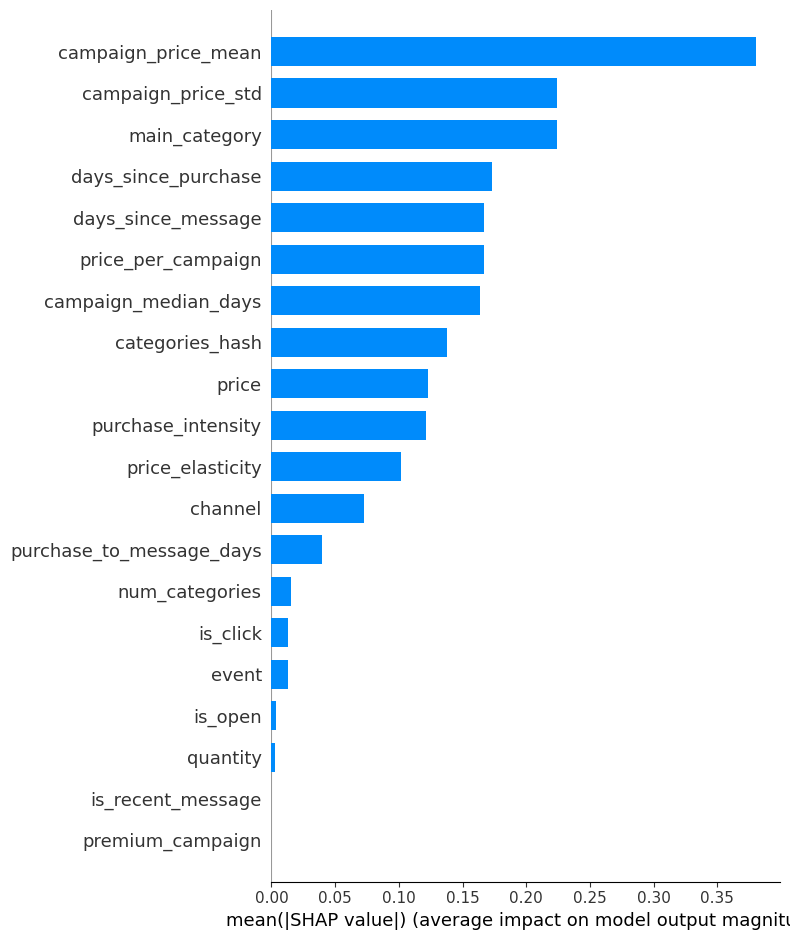

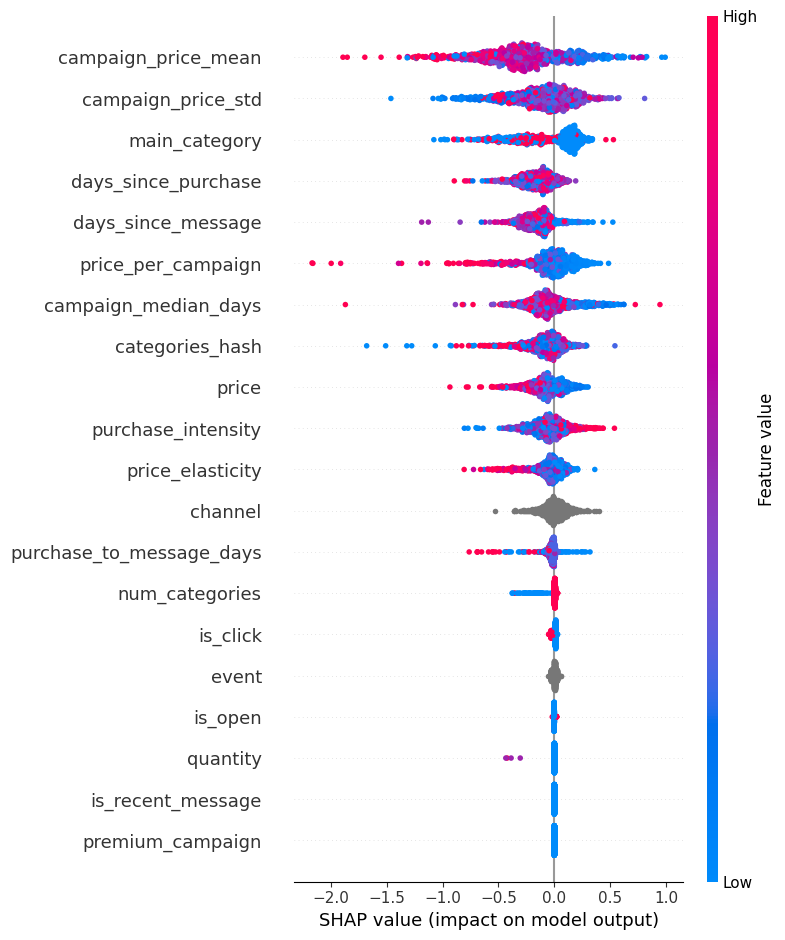

In [42]:
print("\n=== SHAP Analysis ===")
explainer = shap.TreeExplainer(model)
X_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
shap_values = explainer.shap_values(X_sample)

# Барплот
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

# Рассеяние
shap.summary_plot(shap_values, X_sample, show=True)


---

### 📈 Вывод по результатам SHAP-анализa важности признаков

Анализ влияния признаков модели машинного обучения с использованием SHAP (SHapley Additive ExPlanations) позволил выявить ключевые факторы, влияющие на вероятность отклика пользователя на маркетинговую кампанию.

#### 🔝 Основные факторы, увеличивающие вероятность отклика:

1. **Низкая средняя цена кампании (`campaign_price_mean`)** — пользователи чаще откликаются на предложения с низкой стоимостью.
2. **Низкое стандартное отклонение цен (`campaign_price_std`)** — предложения с одинаковыми или стабильно низкими ценами вызывают больше доверия и интереса.
3. **Высокая эластичность цены (`price_elasticity`)** — пользователи, чувствительные к цене, с большей вероятностью реагируют на акции.
4. **Недавние контакты (`days_since_message`, `days_since_purchase`)** — чем меньше времени прошло с момента последнего взаимодействия или покупки, тем выше вероятность отклика.

#### ❌ Факторы, снижающие вероятность отклика:

1. **Высокая средняя цена** — пользователи игнорируют дорогие предложения.
2. **Долгий перерыв с момента последнего сообщения** — если пользователь давно не получал коммуникации, интерес к предложениям снижается.
3. **Большое количество дней с момента последней покупки** — пользователи теряют актуальность к продукту.

#### 🧠 Другие важные наблюдения:

* **Тип категории (`main_category`, `categories_hash`)** играет значимую роль — определённые категории товаров вызывают больше интереса.
* **Интенсивность покупок (`purchase_intensity`)** — активные пользователи более склонны к повторным взаимодействиям.
* **Канал коммуникации (`channel`)** тоже влияет, хотя и слабее — стоит протестировать наиболее эффективные.

---

### ✅ Рекомендации:

1. **Сегментировать аудиторию по чувствительности к цене и времени отклика** — адаптировать предложения и сроки рассылки.
2. **Фокусироваться на актуальных, дешёвых и однородных предложениях** — они наиболее эффективны.
3. **Периодически напоминать о себе активным пользователям** — особенно в первые дни после последней покупки или взаимодействия.

---

